# 11.7. Adagrad

### The Algorithm

In [ ]:
!pip install d2l

In [2]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

epoch 20, x1: -2.382563, x2: -0.158591


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


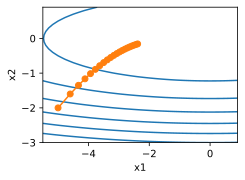

In [3]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

epoch 20, x1: -0.002295, x2: -0.000000


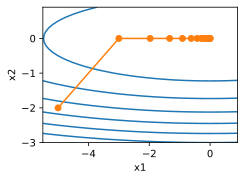

In [4]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

### Implementation from Scratch

In [5]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

loss: 0.242, 0.032 sec/epoch


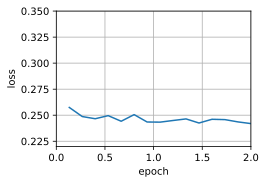

In [6]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

### Concise Implementation

loss: 0.242, 0.019 sec/epoch


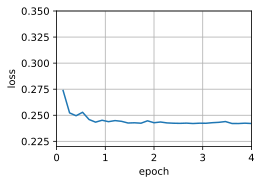

In [7]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

### Summary

- Adagrad decreases the learning rate dynamically on a per-coordinate basis.

- It uses the magnitude of the gradient as a means of adjusting how quickly progress is achieved - coordinates with large gradients are compensated with a smaller learning rate.

- Computing the exact second derivative is typically infeasible in deep learning problems due to memory and computational constraints. The gradient can be a useful proxy.

- If the optimization problem has a rather uneven structure Adagrad can help mitigate the distortion.

- Adagrad is particularly effective for sparse features where the learning rate needs to decrease more slowly for infrequently occurring terms.

- On deep learning problems Adagrad can sometimes be too aggressive in reducing learning rates. We will discuss strategies for mitigating this in the context of Section 11.10.

# 11.8. RMSProp

### The Algorithm

In [ ]:
!pip install mxnet

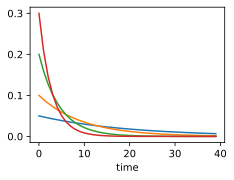

In [16]:
%matplotlib inline
import math
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = np.arange(40).asnumpy()
    d2l.plt.plot(x, (1-gamma) * gamma ** x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time');

###  Implementation from Scratch

epoch 20, x1: -0.010599, x2: 0.000000


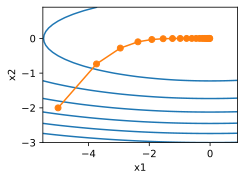

In [17]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

In [18]:
def init_rmsprop_states(feature_dim):
    s_w = np.zeros((feature_dim, 1))
    s_b = np.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        s[:] = gamma * s + (1 - gamma) * np.square(p.grad)
        p[:] -= hyperparams['lr'] * p.grad / np.sqrt(s + eps)

loss: 0.245, 0.175 sec/epoch


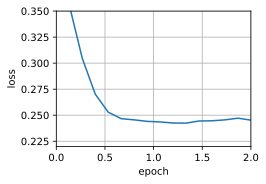

In [19]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

### Concise Implementation

loss: 0.245, 0.087 sec/epoch


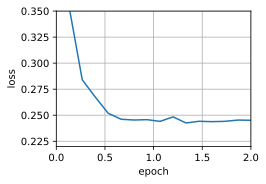

In [20]:
d2l.train_concise_ch11('rmsprop', {'learning_rate': 0.01, 'gamma1': 0.9},
                       data_iter)

### Summary

- RMSProp is very similar to Adagrad insofar as both use the square of the gradient to scale coefficients.

- RMSProp shares with momentum the leaky averaging. However, RMSProp uses the technique to adjust the coefficient-wise preconditioner.

- The learning rate needs to be scheduled by the experimenter in practice.

- The coefficient  determines how long the history is when adjusting the per-coordinate scale.

# 11.9. Adadelta

### Implementation

In [21]:
%matplotlib inline
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

def init_adadelta_states(feature_dim):
    s_w, s_b = np.zeros((feature_dim, 1)), np.zeros(1)
    delta_w, delta_b = np.zeros((feature_dim, 1)), np.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        # In-place updates via [:]
        s[:] = rho * s + (1 - rho) * np.square(p.grad)
        g = (np.sqrt(delta + eps) / np.sqrt(s + eps)) * p.grad
        p[:] -= g
        delta[:] = rho * delta + (1 - rho) * g * g

loss: 0.243, 0.170 sec/epoch


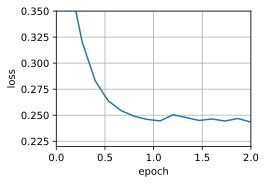

In [22]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

loss: 0.243, 0.163 sec/epoch


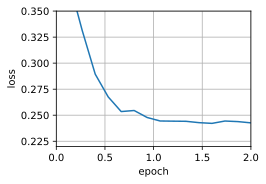

In [23]:
d2l.train_concise_ch11('adadelta', {'rho': 0.9}, data_iter)

### Summary

- Adadelta has no learning rate parameter. Instead, it uses the rate of change in the parameters itself to adapt the learning rate.

- Adadelta requires two state variables to store the second moments of gradient and the change in parameters.

- Adadelta uses leaky averages to keep a running estimate of the appropriate statistics.

# 11.10. Adam

### Implementation

In [24]:
%matplotlib inline
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

def init_adam_states(feature_dim):
    v_w, v_b = np.zeros((feature_dim, 1)), np.zeros(1)
    s_w, s_b = np.zeros((feature_dim, 1)), np.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad
        s[:] = beta2 * s + (1 - beta2) * np.square(p.grad)
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p[:] -= hyperparams['lr'] * v_bias_corr / (np.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

loss: 0.245, 0.206 sec/epoch


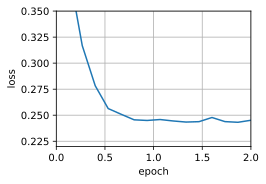

In [25]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

loss: 0.243, 0.075 sec/epoch


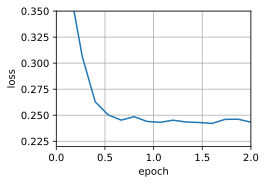

In [26]:
d2l.train_concise_ch11('adam', {'learning_rate': 0.01}, data_iter)

### Yogi

loss: 0.244, 0.188 sec/epoch


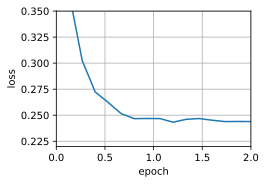

In [27]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad
        s[:] = s + (1 - beta2) * np.sign(
            np.square(p.grad) - s) * np.square(p.grad)
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p[:] -= hyperparams['lr'] * v_bias_corr / (np.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

### Summary

- Adam combines features of many optimization algorithms into a fairly robust update rule.

- Created on the basis of RMSProp, Adam also uses EWMA on the minibatch stochastic gradient.

- Adam uses bias correction to adjust for a slow startup when estimating momentum and a second moment.

- For gradients with significant variance we may encounter issues with convergence. They can be amended by using larger minibatches or by switching to an improved estimate for s_t. Yogi offers such an alternative.

# 11.11. Learning Rate Scheduling

### Toy Problem

In [30]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l

In [31]:
def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [32]:
# The code is almost identical to `d2l.train_ch6` defined in the
# lenet section of chapter convolutional neural networks
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # Using PyTorch In-Built scheduler
                scheduler.step()
            else:
                # Using custom defined scheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

train loss 0.122, train acc 0.953, test acc 0.898


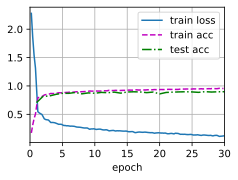

In [33]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

### Schedulers

In [34]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


In [35]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

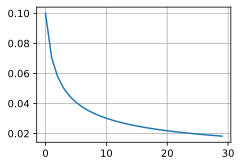

In [36]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.281, train acc 0.896, test acc 0.876


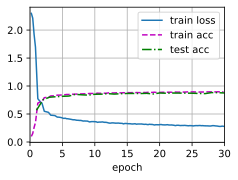

In [37]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### Factor Scheduler

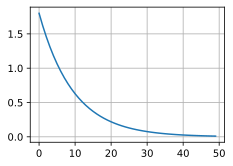

In [38]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

### Multi Factor Scheduler

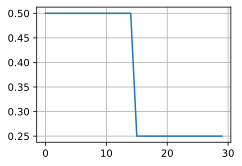

In [39]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                  for t in range(num_epochs)])

train loss 0.199, train acc 0.925, test acc 0.893


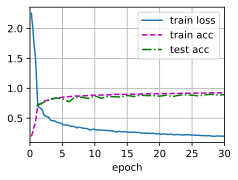

In [40]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### Cosine Scheduler

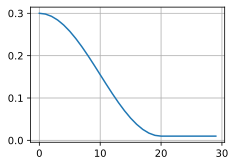

In [41]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.243, train acc 0.910, test acc 0.885


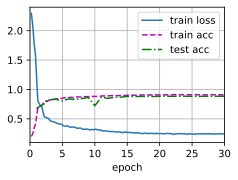

In [42]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### Warmup

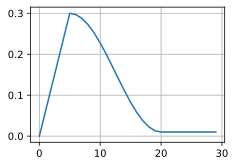

In [43]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.181, train acc 0.934, test acc 0.900


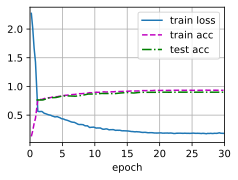

In [44]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### Summary

- Decreasing the learning rate during training can lead to improved accuracy and (most perplexingly) reduced overfitting of the model.

- A piecewise decrease of the learning rate whenever progress has plateaued is effective in practice. Essentially this ensures that we converge efficiently to a suitable solution and only then reduce the inherent variance of the parameters by reducing the learning rate.

- Cosine schedulers are popular for some computer vision problems. See e.g., GluonCV for details of such a scheduler.

- A warmup period before optimization can prevent divergence.

- Optimization serves multiple purposes in deep learning. Besides minimizing the training objective, different choices of optimization algorithms and learning rate scheduling can lead to rather different amounts of generalization and overfitting on the test set (for the same amount of training error).